In [16]:
# load the data
from datetime import time, timedelta
from os import listdir
from os.path import join

def subtract_time(first: time, second: time):
    return timedelta(
        days=0,
        seconds=first.second - second.second,
        minutes=first.minute - second.minute,
        hours = first.hour - second.hour
    )

def read_data(filename):
    result = []
    last = None
    for line in open(filename, "r", encoding="utf-8-sig"):
        parts = line.strip().split('\t')
        timestamp = time.fromisoformat(parts[0])

        if last is not None:
            duration = subtract_time(timestamp, last[0])
            result.append((timestamp, duration, *last[1:]))

        if parts[1] != "finish":
            last = (timestamp, *parts[1:])
        else:
            last = (timestamp, "nothing")

    return result

files = [i for i in listdir() if i.endswith(".csv")]
data = {filename.rstrip(".csv"): read_data(filename) for filename in files}

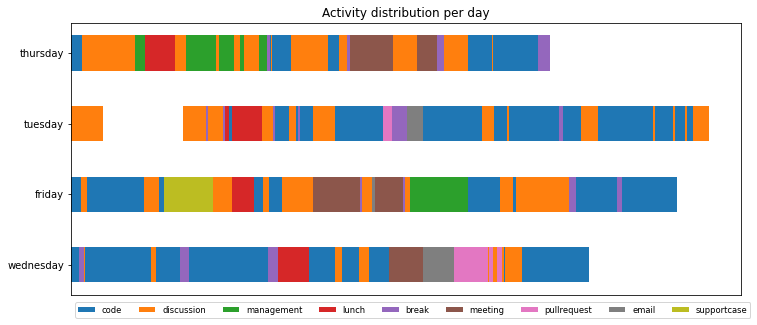

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 5))
ax.invert_yaxis()
ax.xaxis.set_visible(False)

bars = {}

for day, daydata in data.items():
    widths = np.array([activity[1].total_seconds() for activity in daydata])
    labels = np.array([activity[2] for activity in daydata])
    starts = widths.cumsum() - widths
    for width, activity, start in zip(widths, labels, starts):
        if activity not in bars:
            bars[activity] = {"width": [], "start": [], "label": []}
        bars[activity]["width"].append(width)
        bars[activity]["start"].append(start)
        bars[activity]["label"].append(day)

for cat, catdata in bars.items():
    if cat != "nothing":
        ax.barh(catdata["label"], catdata["width"], left=catdata["start"], height=0.5,
            label=cat, align="center")

ax.legend(ncol=len(bars)-1, bbox_to_anchor=(0, -0.1),
          loc='lower left', fontsize='small')

plt.title("Activity distribution per day")
plt.show()

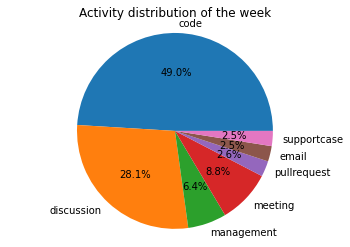

In [20]:
data_by_activity = {}
for day, daydata in data.items():
    for _, duration, activity, *_ in daydata:
        if activity in ("nothing", "lunch", "break"):
            continue
        if activity not in data_by_activity:
            data_by_activity[activity] = 0
        data_by_activity[activity] += duration.total_seconds()

fig1, ax1 = plt.subplots()
ax1.pie(data_by_activity.values(), labels=data_by_activity.keys(), autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Activity distribution of the week")
plt.show()

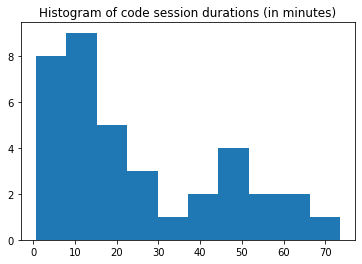

In [19]:
# code histogram
code_durations = [duration.total_seconds() / 60.0 for day, daydata in data.items() for _, duration, activity, *_ in daydata if activity == "code"]
fig, ax = plt.subplots()
ax.hist(code_durations)

plt.title("Histogram of code session durations (in minutes)")
plt.show()

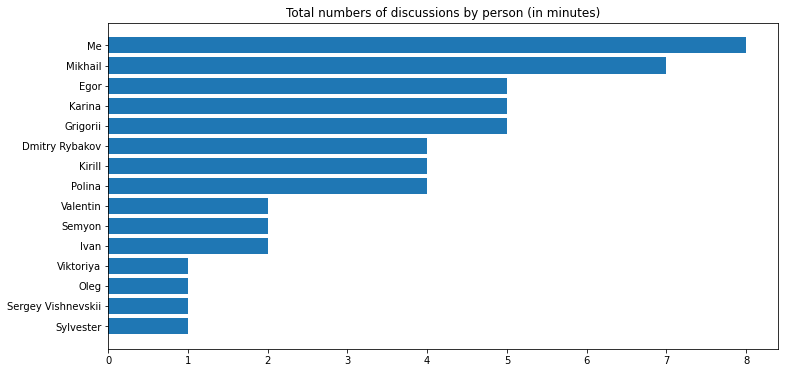

In [18]:
discussions = [(interval[1], interval[3]) for day, daydata in data.items() for interval in daydata if interval[2] == "discussion"]
discussions_by_person = {}
for duration, person in discussions:
    if person not in discussions_by_person:
        discussions_by_person[person] = []
    discussions_by_person[person].append(duration)

values = sorted([(name, len(d)) for name, d in discussions_by_person.items()], key=lambda x: x[1])
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh([name for name, _ in values], width=[number for _, number in values])
plt.title("Total numbers of discussions by person (in minutes)")
plt.show()

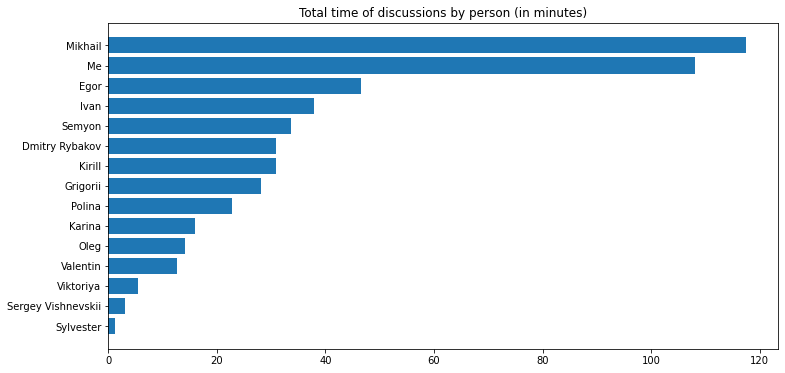

In [15]:
# total duration of discussions by person
values = sorted([(name, sum([duration.total_seconds() / 60.0 for duration in d])) for name, d in discussions_by_person.items()], key=lambda x: x[1])
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh([name for name, _ in values], width=[number for _, number in values])
ax.set_title("Total time of discussions by person (in minutes)")
plt.show()

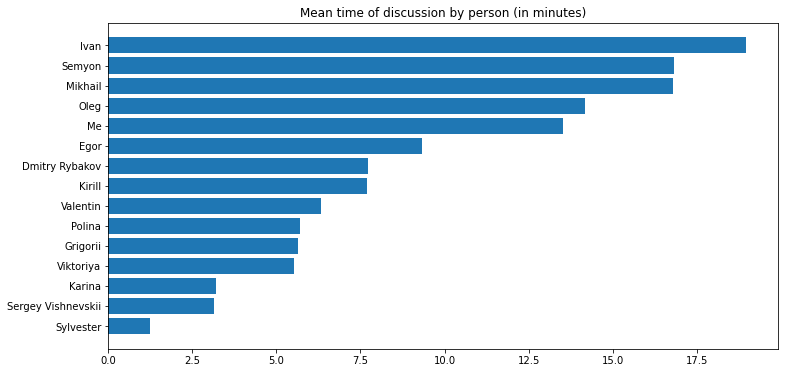

In [17]:
# mean duration of a discussion by person
values = sorted([(name, sum([duration.total_seconds() / 60.0 for duration in d])/float(len(d))) for name, d in discussions_by_person.items()], key=lambda x: x[1])
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh([name for name, _ in values], width=[number for _, number in values])
plt.title("Mean time of discussion by person (in minutes)")
plt.show()